# Modelling stock returns and volatility


## Procedure

Building a volatility model consists of several steps.

1. Specify the mean equation. In our case, we need to investigate the mean of our returns and check for serial
dependence. If required, we can fit a model and remove linear dependence structures through filtering. Technically,
we can stop here and use the model to do forecasts, however, we have seen that volatility changes over time and needs
adequate treatment.

2. In the next step, test the residuals for ARCH/GARCH effects and specify a volatility model. In most cases, a low order
GARCH model is used, e.g. GARCH(1,1).

## Setup - Data Foundation and Return Series

In the first step, load the data, compute log-returns and visualize the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from arch import arch_model


In [2]:
# Load Data and set index
df_price = pd.read_csv('GDAX.csv')
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price.set_index('Date', inplace=True)

# Select Column
col_name = 'Adj Close'

# Compute Returns and Log-Returns
df_returns = df_price[col_name].pct_change().dropna()
log_return_adj_close = np.log(df_price[col_name]).diff(1).dropna()

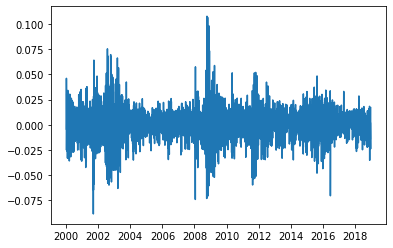

In [3]:
# Plot return series
plt.plot(log_return_adj_close)
plt.show()

In [4]:
# log_return_adj_close.index = pd.DatetimeIndex(log_return_adj_close.index).to_period('D')

In [5]:
# log_return_adj_close.index

As was mentioned in the previous lectures, we can clearly see volatility clusters which are characteristic for
financial time series.


## Test for Stationarity: Augmented Dickey Fuller

Computing (net) returns corresponds to differencing and normalization. Therefore, we may assume that the
time series is stationary. Nevertheless, verify this by the Augmented-Dickey Fuller test which is a statistical test
whether unit roots (Nullstelle) are present. In particular, it tests if the autoregressive part of the model has
a coefficient that is equal to one.

<br>

$H_0:$ the series follows a unit-root process <br/>
$H_1:$ the data is (trend-)stationary <center>

In [6]:
adfuller(log_return_adj_close)

(-33.05544657271088,
 0.0,
 4,
 4789,
 {'1%': -3.4317162160324406,
  '5%': -2.8621437138975274,
  '10%': -2.5670913586453366},
 -26677.524574216943)

The first value of the output is the ADF-Statistic, the second line displays the p-value. Clearly, $H_0$ is rejected
with a diminishing p-value which implies stationarity of our time series data sample.

For more details on ADF see
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html


## Test for Serial Correlation: Ljung-Box Test

Next, plot the acf function and see if any lags are significant by eye-balling it. Note that simply showing
the correlogram is not sufficient if you wish to deliver a well-founded statistical analysis.

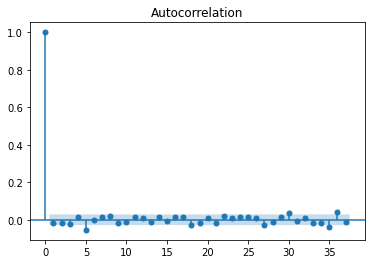

In [7]:
acf_plt = plot_acf(log_return_adj_close)

Based on the plot it seems that the 2. and 3. lag are significant although only on a minor significance level. Again,
employ a statistical test to check for serial correlation properly. One possible test is the so called
Ljung-Box test.

<br>

$H_0:$ data sample is independently distributed <br/>
$H_1:$ data sample exhibit serial correlation

In [8]:
acorr_ljungbox(log_return_adj_close, lags = 10, return_df=True)

,lb_stat,lb_pvalue
1,1.067781,0.301447
2,2.567519,0.276994
3,4.771340,0.189327
4,5.839147,0.211487
5,20.005599,0.001247
6,20.049145,0.002714
7,20.937407,0.003864
8,22.732974,0.003725
9,23.804151,0.004622
10,24.803850,0.005730


For $lag=1$, $H_0$ cannot be rejected hence the series is independently distributed. However, this cannot be said
for higher lags. An interesting thing is that we actually don't rely entirely on these findings for model selection.
In fact, model selection is done by using information criteria. However, the test hints to the correct model
specification.


## Model Selection Part 1: Information Criteria

We aim to use a statistical model in order to predict future value. The typical question is, how do we choose?
Model selection is done from an information-theoretic point of view. Finding the right is always a trade-off
between fit and complexity. The more complex your model is the better the fit, however this might worsen the
prediction capabilities.

<br>

The Akaike Information Criterion (AIC) is defined as

$$AIC = -2l(\hat{\theta}) + 2p$$

<br>

where ***$\theta$*** is the vector of estimated parameters and $p$ the number of parameters. Thus, we penalize the
model as it becomes too complex. The Akaike information criterion is actually an estimate of information loss. It
changes with increasing sample size.

<br>

Consider the Bayesian Information Criterion (BIC)

$$BIC = -2l(\hat{\theta}) + P log(n)$$

Without going into details, the BIC information criterion compares the models at hand with a benchmark. Once the
sample size tends to infinity, BIC will select the asymptotic true model.

For detailed introduction see [1], [2] and [A].

<br>

Bottom line: Use the BIC with large sample sizes and AIC for smaller sample sizes. Among the models select that model
with the smallest information criterion.

## Model Selection Part 2: Selecting the right model

For the choice of arima models: fit several models and choose the on with the "best" information criterion.

In [9]:
# Fit to AR(1) model & print AIC):

mod_ar1 = ARIMA(log_return_adj_close, order=(1,0,0), freq=None)
res_ar1 = mod_ar1.fit()
print(res_ar1.summary())

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 4794
Model:                     ARMA(1, 0)   Log Likelihood               13412.304
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 10 Sep 2021   AIC                         -26818.609
Time:                        12:22:49   BIC                         -26799.184
Sample:                             0   HQIC                        -26811.786
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.134e-05      0.000      0.340      0.734      -0.000       0.000
ar.L1.Adj Close    -0.0149      0.014     -1.033      0.302      -0.043       0.013
                                

/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has n

In [10]:
# Fit to AR(2) model & print AIC):

mod_ar2 = ARIMA(log_return_adj_close, order=(2,0,0))
res_ar2 = mod_ar2.fit()
print(res_ar2.summary())

/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has n

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 4794
Model:                     ARMA(2, 0)   Log Likelihood               13413.074
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 10 Sep 2021   AIC                         -26818.148
Time:                        12:22:49   BIC                         -26792.247
Sample:                             0   HQIC                        -26809.051
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             7.15e-05      0.000      0.347      0.729      -0.000       0.000
ar.L1.Adj Close    -0.0152      0.014     -1.052      0.293      -0.044       0.013
ar.L2.Adj Close    -0.0179      

In [11]:
# Fit to MA(1) model & print AIC):

mod_ma1 = ARIMA(log_return_adj_close, order=(0,0,1))
res_ma1 = mod_ma1.fit()
print(res_ma1.summary())

/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has n

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 4794
Model:                     ARMA(0, 1)   Log Likelihood               13412.325
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 10 Sep 2021   AIC                         -26818.649
Time:                        12:22:49   BIC                         -26799.224
Sample:                             0   HQIC                        -26811.826
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.134e-05      0.000      0.340      0.734      -0.000       0.000
ma.L1.Adj Close    -0.0155      0.015     -1.052      0.293      -0.044       0.013
                                

In [12]:
# Fit to ARMA(1,1) model & print AIC:
mod_arma11 = ARIMA(log_return_adj_close, order=(1,0,1))
res_arma11 = mod_arma11.fit()
print(res_arma11.summary())

/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has n

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 4794
Model:                     ARMA(1, 1)   Log Likelihood               13414.414
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 10 Sep 2021   AIC                         -26820.828
Time:                        12:22:50   BIC                         -26794.928
Sample:                             0   HQIC                        -26811.731
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             7.16e-05      0.000      0.369      0.712      -0.000       0.000
ar.L1.Adj Close     0.7516      0.130      5.780      0.000       0.497       1.006
ma.L1.Adj Close    -0.7735      

As you we can see, almost all models have roughly the same information criterion values, e.g. AIC, for simplicity we will
choose an ARMA(1,1) process to model our mean of the returns. If the model was specified correctly, the residuals should
be white noise. Run the following diagnostics:

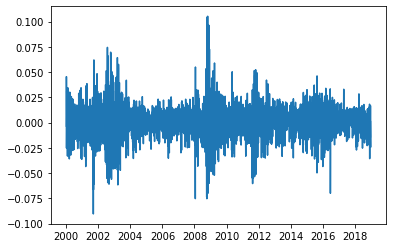

In [13]:
plt.plot(res_arma11.resid)

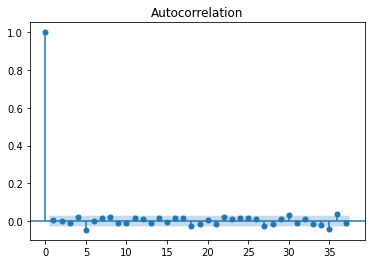

In [14]:
acf_plt = plot_acf(res_arma11.resid)

In [15]:
acorr_ljungbox(res_arma11.resid, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,0.171130,0.679109
2,0.188455,0.910076
3,0.616427,0.892662
4,3.177093,0.528639
5,13.656469,0.017945
6,13.674930,0.033486
7,15.105303,0.034673
8,17.437344,0.025864
9,18.150201,0.033470
10,18.863244,0.042034


The residuals will be the new time series to work with. It can be interpreted as the log-returns but filtered for
linear dependencies.

In [16]:
log_return_adj_closed_filtered = res_arma11.resid

## Test for ARCH/GARCH effects

Intuitively, strong serial correlation should still exist in the filtered time series but in terms of squared returns.
For that plot the acf of the squared filtered returns and verify this by applying the Ljung-Box Test for serial
correlation again.


,lb_stat,lb_pvalue
1,174.326225,8.401240e-40
2,527.747682,2.517949e-115
3,920.582590,3.037197e-199
4,1160.678834,5.323820e-250
5,1497.256160,0.000000e+00
6,1671.263045,0.000000e+00
7,1960.583133,0.000000e+00
8,2172.971921,0.000000e+00
9,2489.658564,0.000000e+00
10,2721.053085,0.000000e+00


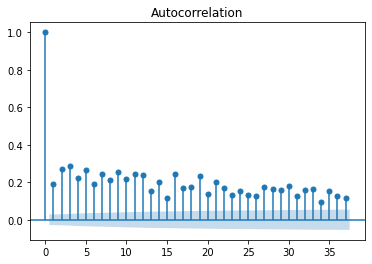

In [17]:
sqr_fil_returns = np.square(log_return_adj_closed_filtered)

acf_plt = plot_acf(sqr_fil_returns)

acorr_ljungbox(sqr_fil_returns, lags=10, return_df=True)

Clearly in all cases the nullhypothesis is rejected.

## Fitting a GARCH(1,1) model

In [18]:
mod_garch11 = arch_model(log_return_adj_closed_filtered, p=1, q=1, dist='normal')
res_garch11 = mod_garch11.fit()
print(res_garch11.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 118011953018.7255
Iteration:      2,   Func. Count:     21,   Neg. LLF: 6.1036691950498056e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5267580796668023.0
Iteration:      4,   Func. Count:     46,   Neg. LLF: 1.1911791722597648e+17
Iteration:      5,   Func. Count:     61,   Neg. LLF: 5.397940229757587e+16
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1030014.974834614
Iteration:      7,   Func. Count:     86,   Neg. LLF: 464130452190.47614
Iteration:      8,   Func. Count:    101,   Neg. LLF: 1.0513260539465003e+29
Iteration:      9,   Func. Count:    116,   Neg. LLF: 1.13140453672076e+21
Iteration:     10,   Func. Count:    124,   Neg. LLF: 2792.7173665662135
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2792.717435035196
            Iterations: 14
            Function evaluations: 124
            Gradient evaluations: 10
                     Constant Mean - GARCH Mo

/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


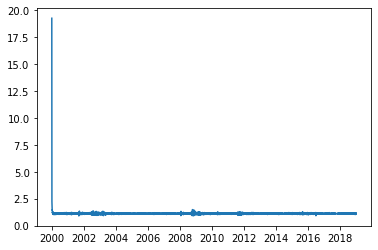

In [19]:
# standardized residuals = returns/conditional volatility

plt.plot(res_garch11.std_resid)
plt.show()

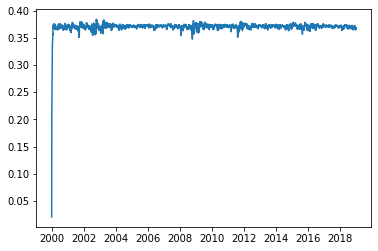

In [20]:
# conditional volatility

plt.plot(res_garch11.conditional_volatility)
plt.show()

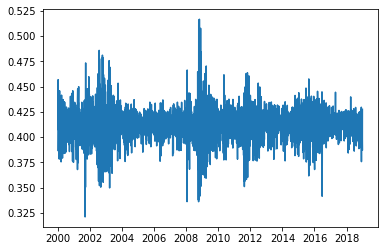

In [27]:
# unstandardized residuals = conditional volatility*standard white noise

plt.plot(res_garch11.resid)
plt.show()


In order to assess the quality of the fit, we have to evaluate how many predicted datapoints lie within a given confidence
intervall. In our example with normal distribution, the "coverage" can be simply calculate by $1.96 * \hat{\sigma_t}$.



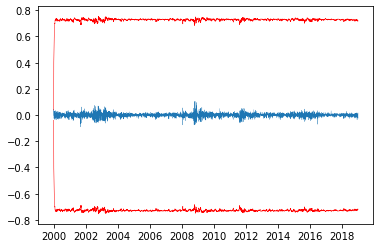

In [26]:
coverage_pos = res_garch11.conditional_volatility * 1.96
coverage_neg = - coverage_pos

fig, ax = plt.subplots()

# Customize data mapping appearance
ax.plot(log_return_adj_closed_filtered, linewidth = 0.3)
ax.plot(coverage_pos, linewidth=0.5, color='red')
ax.plot(coverage_neg, linewidth=0.5, color='red')
plt.show()


In [23]:
pos_exedence = coverage_pos < log_return_adj_closed_filtered
neg_exedence = coverage_neg > log_return_adj_closed_filtered
(pos_exedence.sum() + neg_exedence.sum())/len(log_return_adj_closed_filtered)


0.0

We can see that our model roughly covers 95% of our sample which is for purpose good enough.


## Forecasting Volatility

Let us now do some mean and volatility forecast. The ARCH package has a forecast object for this task. Be default
forecasts will only be produced for the final observation in the sample so that they are out-of-sample.


In [24]:
obj_forecast = res_garch11.forecast()

print(obj_forecast.mean.iloc[-3:])
print(obj_forecast.residual_variance.iloc[-3:])
print(obj_forecast.variance.iloc[-3:])


                 h.1
Date                
2018-12-21       NaN
2018-12-27       NaN
2018-12-28 -0.411453
                 h.1
Date                
2018-12-21       NaN
2018-12-27       NaN
2018-12-28  0.135863
                 h.1
Date                
2018-12-21       NaN
2018-12-27       NaN
2018-12-28  0.135863


/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [25]:
obj_forecast = res_garch11.forecast(horizon=3)

print(obj_forecast.mean.iloc[-3:])
print(obj_forecast.residual_variance.iloc[-3:])
print(obj_forecast.variance.iloc[-3:])


                 h.1       h.2       h.3
Date                                    
2018-12-21       NaN       NaN       NaN
2018-12-27       NaN       NaN       NaN
2018-12-28 -0.411453 -0.411453 -0.411453
                 h.1       h.2       h.3
Date                                    
2018-12-21       NaN       NaN       NaN
2018-12-27       NaN       NaN       NaN
2018-12-28  0.135863  0.132728  0.129665
                 h.1       h.2       h.3
Date                                    
2018-12-21       NaN       NaN       NaN
2018-12-27       NaN       NaN       NaN
2018-12-28  0.135863  0.132728  0.129665


/home/dm/Desktop/PFF/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


### Reference

[1] Hastie T., Tibshirani R., Friedman J. (2017): The Elements of Statistical Learning

[2] Burnham K.P., Anderson D.R. (2004): Multimodel Inference: Understanding AIC and BIC in Model Selection

[A] More on Akaike information criterion
    https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2

